# Time series prediction (Part 1 - 1 day)

**NB objective**
- [ ] Get to know the theory behind time series
- [ ] Discover main time series analysis challenges

**Required librairies**
- [ ] matplotlib
- [ ] numpy
- [ ] pandas
- [ ] seaborn
- [ ] pmdarima

## How to deal with Time series ?

To be brief, when dealing with time series, few checks are required and for your greatest pleasure... a bit of theory helps... 
😁

### Theory

#### Tendancy

#### Seasonality

#### Autocorrelation partial or not

We can calculate the correlation for time-series observations with observations from previous time steps

→ Also called *lags
→ T*his is called a serial correlation, or an autocorrelation cause it is based on the same data but at a previous time

---

**ACF** : plot of the autocorrelation of a dataset of a time series by lag is called the **A**uto**C**orrelation **F**unction
The ACF measures the correlation between a data point in a series and its lagged values, which are previous values in the series. It tells us how related a data point is to its past values. The ACF considers both direct and indirect relationships between the data point and its lagged values.

---

**PACF** : **P**artial **A**uto**C**orrelation **F**unction
An intuitive description can be "the amount of correlation with each lag that is not accounted for by more recent lags".

Autocorrelation satisfies a property that we could call *dampened transitivity*. 
If 𝑥_t is correlated with 𝑥_(𝑡−1) by some amount 𝜌<0
then 𝑥𝑡−(t-1) is correlated with 𝑥_(𝑡−2) by 𝜌. 
This implies that 𝑥_t is correlated with 𝑥_(t-2), although by some amount smaller than 𝜌

On the other hand, the PACF measures the correlation between a data point and its lagged values while removing the effects of intervening time points. In other words, it only measures the direct relationship between the data point and its lagged values, without considering any indirect relationships.

To put it simply, the ACF tells us how a data point is related to all of its past values, while the PACF tells us how a data point is directly related to its immediate lagged values, without considering any other intermediate values.

---

Partial autocorrelation computes the "pure" correlation between

𝑥_t and 𝑥_(𝑡−2) by removing the "transitive" correlation

$ p(h) = corr(Y_t, Y_t-_h) $

#### Stationarity

#### Heteroskedasticity

In [4]:
# Explain and resume conditions for a time series to be heteroskedastic
# Why is it important to test heteroskedasticity before any regression analysis?

# Time series analysis

**Data analysis**

In [5]:
# Load data
from pmdarima.datasets import load_airpassengers
# Write definitions to visualize, describe and eventually clean data
# Write definition to assess autocorrelation and stationarity 
# Write definition to test the heteroskedasticity
# Write definition to change sampling (D/M/Y)

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

### Import data

In [7]:
cwd = os.getcwd()

In [8]:
data_path = os.path.join(cwd, "data/AirPassengers.csv")

In [9]:
df = pd.read_csv(data_path)

In [10]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


### Rework dataframe 

In [11]:
# Assuming your DataFrame is called df
# Convert the "Month" column to datetime format
df["Month"] = pd.to_datetime(df["Month"])

# Set the "Month" column as the index
df.set_index("Month", inplace=True)

In [12]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## First Analysis

### Graphical Analysis

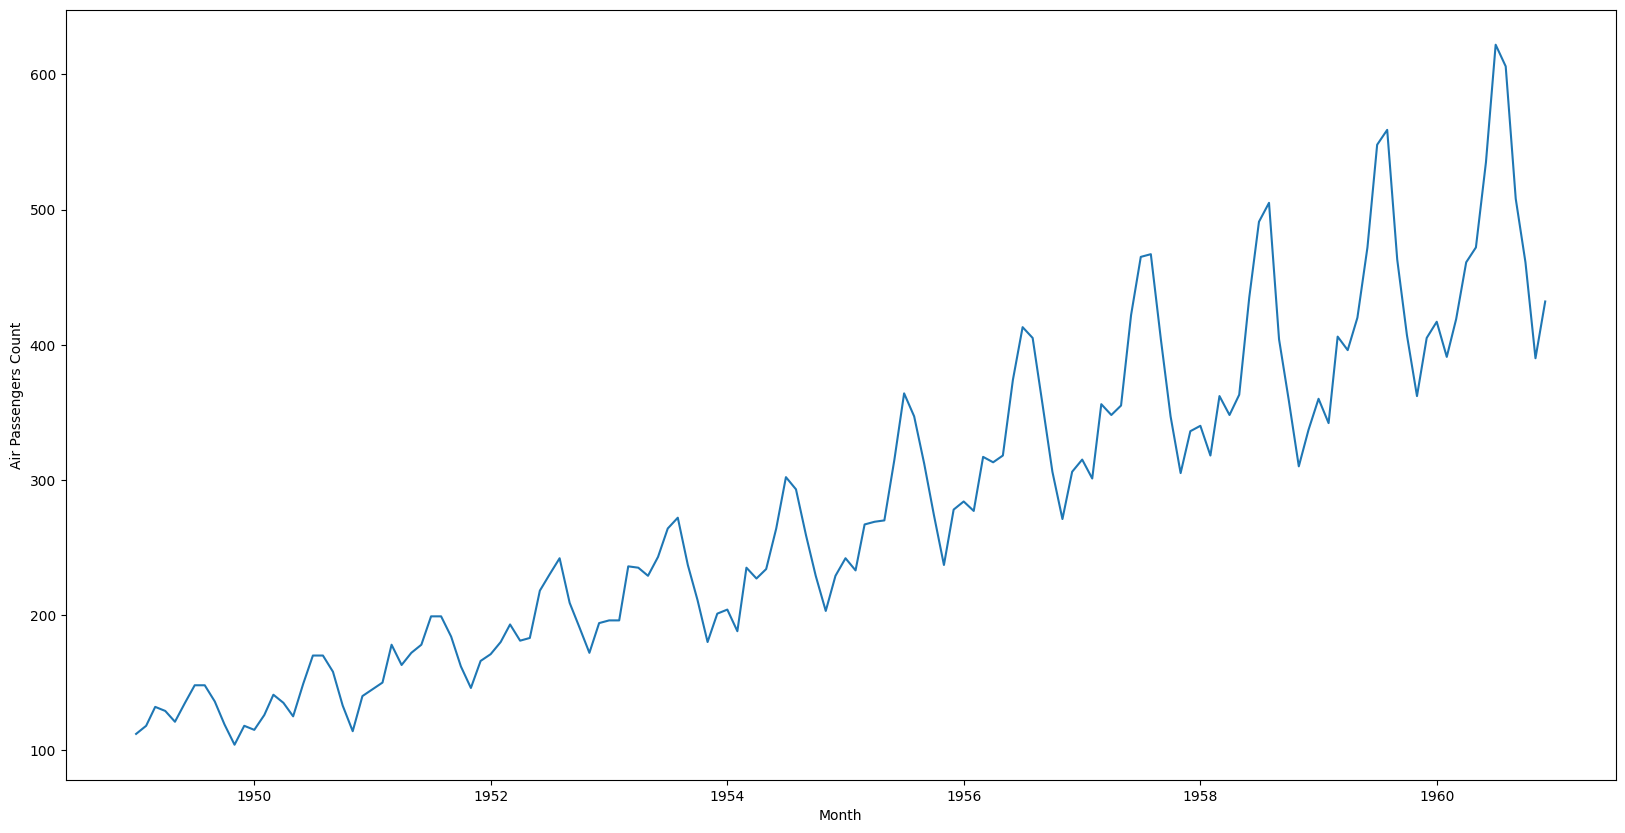

In [18]:
plt.figure(figsize=(20,10))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")
plt.plot(df)

### Variance Study

In [ ]:
window_size = 12
rolling_var = df.rolling(window=window_size).var()


# Plot the rolling variance evolution
plt.figure(figsize=(10, 6))
plt.plot(rolling_var.index, rolling_var)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title(f'Rolling Variance Evolution of Time Series (Window Size: {window_size})')
plt.grid(True)
plt.show()

-> Increasing variance over time suggesting heteroskatic datas

### Study of Trend

In [ ]:
trend = df['#Passengers'].rolling(window=12).mean()

In [ ]:
# Plot the trend
plt.plot(trend)
plt.xlabel('Month')
plt.ylabel('Trend')
plt.show()

### Seasonality

In [14]:
# Calculate the seasonality
seasonality = df['#Passengers'] - trend
seasonality = seasonality[seasonality.datetime.year==1954]

NameError: name 'trend' is not defined

In [15]:
plt.plot(seasonality)
plt.xlabel('Month')
plt.ylabel('Seasonality')
plt.show()

NameError: name 'seasonality' is not defined

### Auto-Correlation

In [16]:
import statsmodels.tsa.stattools as stattools

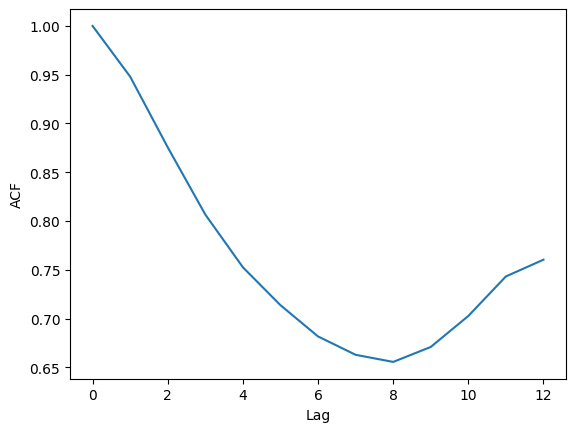

In [17]:
# Calculate the ACF
acf = stattools.acf(df['#Passengers'], nlags=12)

# Plot the ACF
plt.plot(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

### Partial Auto-Correlation

In [93]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

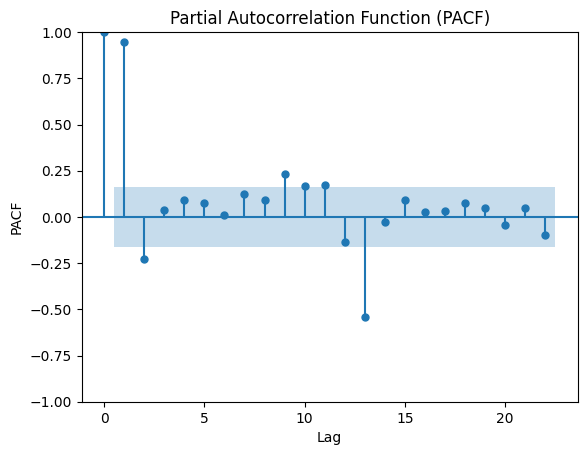

In [95]:
plot_pacf(df['#Passengers'])
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

-> Seems that after 1 month lag, the correlation is within a standart range

### Heteroskedasticity Tests

In [100]:
TEST_NAMES = ['White', 'Breusch-Pagan', 'Goldfeld-Quandt']
FORMULA = 'value ~ time'

In [103]:
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

In [104]:
class Heteroskedasticity:

    @staticmethod
    def het_tests(series: pd.Series, test: str) -> float:
        """
        Testing for heteroskedasticity

        :param series: Univariate time series as pd.Series
        :param test: String denoting the test. One of 'white','goldfeldquandt', or 'breuschpagan'

        :return: p-value as a float.

        If the p-value is high, we accept the null hypothesis that the data is homoskedastic
        """
        assert test in TEST_NAMES, 'Unknown test'

        series = series.reset_index(drop=True).reset_index()
        series.columns = ['time', 'value']
        series['time'] += 1

        olsr = ols(FORMULA, series).fit()

        if test == 'White':
            _, p_value, _, _ = sms.het_white(olsr.resid, olsr.model.exog)
        elif test == 'Goldfeld-Quandt':
            _, p_value, _ = sms.het_goldfeldquandt(olsr.resid, olsr.model.exog, alternative='two-sided')
        else:
            _, p_value, _, _ = sms.het_breuschpagan(olsr.resid, olsr.model.exog)

        return p_value

    @classmethod
    def run_all_tests(cls, series: pd.Series):

        test_results = {k: cls.het_tests(series, k) for k in TEST_NAMES}

        return test_results

In [106]:
test_results = Heteroskedasticity.run_all_tests(df["#Passengers"])
test_results

{'White': 4.345754466128766e-07,
 'Breusch-Pagan': 4.559001856883369e-07,
 'Goldfeld-Quandt': 8.812950329262266e-13}

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461
